In [174]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


import warnings
warnings.filterwarnings("ignore")

In [175]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop_out_val = 0.01 
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=drop_out_val)
        ) #

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=drop_out_val)
        ) # 

        self.pool1 = nn.MaxPool2d(2, 2) # 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_out_val)
        ) # 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_out_val)
        ) # 

        self.pool2 = nn.MaxPool2d(2, 2) # 
        self.convblock100 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) #

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_out_val)
        ) # 

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=drop_out_val)
        ) # 

        self.gap = nn.Sequential(nn.AvgPool2d(3)) # 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock100(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x)

In [176]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,152
             ReLU-11           [-1, 16, 14, 14]               0
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

In [177]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [178]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset), accuracy
        ))
    
    train_loss_graph.append(train_loss)
    train_accuracy_graph.append(accuracy)
    return train_loss_graph, train_accuracy_graph, accuracy

incorrect_examples = []
def test(model, device, test_loader, test_loss_graph, test_accuracy_graph):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy
        ))
    test_loss_graph.append(test_loss)
    test_accuracy_graph.append(accuracy)
    return test_loss_graph, test_accuracy_graph


epoch number  1
Train set: Average loss: 0.0027, Accuracy: 56455/60000 (94.09%)
Test set: Average loss: 0.0846, Accuracy: 9850/10000 (98.50%)

epoch number  2
Train set: Average loss: 0.0007, Accuracy: 58857/60000 (98.09%)
Test set: Average loss: 0.0509, Accuracy: 9891/10000 (98.91%)

epoch number  3
Train set: Average loss: 0.0005, Accuracy: 59139/60000 (98.56%)
Test set: Average loss: 0.0395, Accuracy: 9907/10000 (99.07%)

epoch number  4
Train set: Average loss: 0.0004, Accuracy: 59223/60000 (98.70%)
Test set: Average loss: 0.0380, Accuracy: 9897/10000 (98.97%)

epoch number  5
Train set: Average loss: 0.0004, Accuracy: 59331/60000 (98.89%)
Test set: Average loss: 0.0352, Accuracy: 9909/10000 (99.09%)

epoch number  6
Train set: Average loss: 0.0003, Accuracy: 59350/60000 (98.92%)
Test set: Average loss: 0.0326, Accuracy: 9915/10000 (99.15%)

epoch number  7
Train set: Average loss: 0.0003, Accuracy: 59394/60000 (98.99%)
Test set: Average loss: 0.0359, Accuracy: 9895/10000 (98.95%)


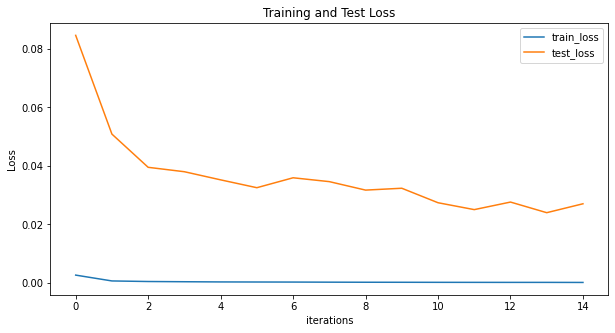

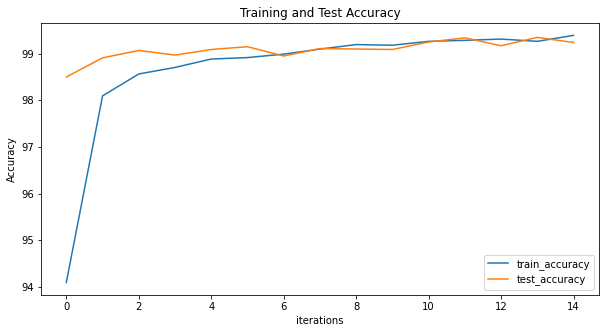

In [179]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_graph = []
train_accuracy_graph = []
test_loss_graph = []
test_accuracy_graph = []
for epoch in range(1, 16):
    print('epoch number ', epoch)
    train_loss_graph, train_accuracy_graph, accuracy = train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph)
    test_loss_graph, test_accuracy_graph = test(model, device, test_loader, test_loss_graph, test_accuracy_graph)

import matplotlib.pyplot as plt

print(train_loss_graph, test_loss_graph)
print(train_accuracy_graph, test_accuracy_graph)
plt.figure(figsize=(10,5))
plt.title("Training and Test Loss")
plt.plot(train_loss_graph,label="train_loss")
plt.plot(test_loss_graph,label="test_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracy_graph,label="train_accuracy")
plt.plot(test_accuracy_graph,label="test_accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
